В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cm_bright_test = ListedColormap(['#FFA833','#33E0FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y, color_map=cm_bright):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=color_map)

In [4]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, neurons_in_layers, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.neurons_in_layers = neurons_in_layers
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self):
        neurons_in_layers = self.neurons_in_layers
        parameters = {}
        for i in range(1, len(neurons_in_layers)):
            parameters["W" + str(i)] = np.random.randn(neurons_in_layers[i], neurons_in_layers[i - 1]) * 0.01
            parameters["b" + str(i)] = np.zeros((neurons_in_layers[i], 1)) #
        self.parameters = parameters
       
    def __forward_propagation(self, X):
        parameters = self.parameters
        caches = []
        A = X
        L = len(parameters) // 2

        for i in range(1, L):
            prev_A = A
            W = parameters["W"+str(i)]
            b = parameters["b"+str(i)]
            
            Z = np.dot(W, prev_A) + b
            linear_cache = (prev_A, W, b)
            
            A = self.__sigmoid(Z)
            activation_cache = Z
            
            cache = (linear_cache, activation_cache)            
            caches.append(cache)   
            
        W = parameters["W"+str(L)]
        b = parameters["b"+str(L)]
        
        Z = np.dot(W, A) + b
        linear_cache = (A, W, b)
            
        AL = self.__sigmoid(Z)
        activation_cache = Z
            
        cache = (linear_cache, activation_cache)            
        caches.append(cache)  
        
        assert(AL.shape == (1,X.shape[1]))
        return AL, caches
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, caches):
        grads = {}
        AL = X
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        
        linear_cache, activation_cache = caches[L-1]
        Z = activation_cache
        s = self.__sigmoid(Z)
        dZ = dAL * s * (1 - s)
        prev_A, W, b = linear_cache
        m = prev_A.shape[1]
        dW = 1 / m * np.dot(dZ, prev_A.T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prev_dA = np.dot(W.T, dZ)
        
        grads["dA" + str(L-1)] = prev_dA
        grads["dW" + str(L)] = dW
        grads["db" + str(L)] = db
        
        for i in reversed(range(L-1)):
            linear_cache, activation_cache = caches[i]
            Z = activation_cache
            s = self.__sigmoid(Z)
            dZ = prev_dA * s * (1 - s)
            prev_A, W, b = linear_cache
            m = prev_A.shape[1]
            dW = 1 / m * np.dot(dZ, prev_A.T)
            db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
            prev_dA = np.dot(W.T, dZ)
            
            grads["dA" + str(i)] = prev_dA
            grads["dW" + str(i + 1)] = dW
            grads["db" + str(i + 1)] = db
        return grads
    
    def __update_parameters(self, grads):
        parameters = self.parameters
        learning_rate = self.learning_rate

        for i in range(len(parameters) // 2):
            parameters["W" + str(i+1)] = parameters["W" + str(i+1)] - learning_rate * grads["dW" + str(i+1)]
            parameters["b" + str(i+1)] = parameters["b" + str(i+1)] - learning_rate * grads["db" + str(i+1)]
            
        self.parameters = parameters
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        self.__initialize_parameters()

        for i in range(0, self.num_iter):
            A, caches = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(A, Y, caches)

            self.__update_parameters(grads)

            if print_cost and i % 100 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 100 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [5]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [6]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


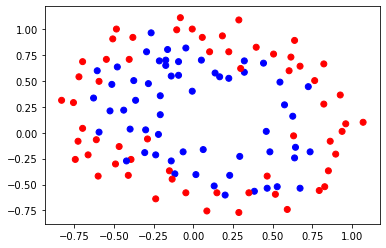

In [7]:
plot_data(X, Y)

In [8]:
cls = NeuralNet(neurons_in_layers = [2, 15, 1], normalize = True, learning_rate = 0.5, num_iter = 4000)

0-th iteration: 0.6934597615496367
100-th iteration: 0.6894805503536215
200-th iteration: 0.6893965220172348
300-th iteration: 0.6892265119745354
400-th iteration: 0.6889198307376679
500-th iteration: 0.6885494237389055
600-th iteration: 0.6882889249920892
700-th iteration: 0.6881466465109513
800-th iteration: 0.6880299011816171
900-th iteration: 0.6878732646882406
1000-th iteration: 0.6876091765148408
1100-th iteration: 0.6870867443361974
1200-th iteration: 0.6858781276403259
1300-th iteration: 0.6828635056763508
1400-th iteration: 0.6759896827670319
1500-th iteration: 0.6622141644450025
1600-th iteration: 0.6387083949188326
1700-th iteration: 0.6134678670748612
1800-th iteration: 0.5959745920507711
1900-th iteration: 0.5861014299483122
2000-th iteration: 0.5808241390889476
2100-th iteration: 0.5774518363062153
2200-th iteration: 0.5714471783998937
2300-th iteration: 0.5519093535207864
2400-th iteration: 0.516441594828593
2500-th iteration: 0.481110772494926
2600-th iteration: 0.45460

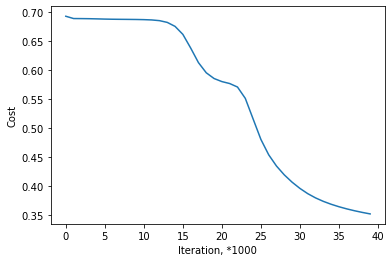

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values.reshape((Y.shape[0], 1)), test_size = 0.2, random_state=10)

cls.fit(X_train, Y_train)

In [10]:
print(cls.parameters)

{'W1': array([[-1.27573298, -0.14650111],
       [-0.00249441, -1.06812839],
       [-1.22231473, -0.1054782 ],
       [-2.49111032, -1.97368836],
       [-1.18727841, -0.08221545],
       [ 0.18118304, -0.93973142],
       [-0.04946017,  1.61391285],
       [ 0.40067639, -1.02161151],
       [-0.30761691, -0.10635298],
       [-1.09536157,  0.17241935],
       [-0.3126052 ,  1.44302384],
       [-0.41053493, -1.37240712],
       [ 0.28239852, -1.10739789],
       [ 0.5716846 , -0.92696295],
       [-1.12110419, -0.03087139]]), 'b1': array([[-2.134171  ],
       [-0.96642383],
       [-2.12075921],
       [ 4.4322549 ],
       [-2.02661847],
       [-2.21451356],
       [-3.4923198 ],
       [-1.55598873],
       [ 0.29135034],
       [-2.64679197],
       [-3.2607739 ],
       [-2.47176402],
       [-1.41163511],
       [-1.7938257 ],
       [-1.56630133]]), 'W2': array([[-2.43880824, -0.90500337, -2.39181106,  9.01458641, -2.24225336,
        -2.72632798, -3.48920011, -1.84566202,  0

In [11]:
Y_prob = cls.predict_proba(X_train)
Y_prob

array([[8.66397991e-01, 1.33602009e-01],
       [2.17065907e-01, 7.82934093e-01],
       [9.99435838e-01, 5.64161788e-04],
       [3.95875010e-01, 6.04124990e-01],
       [1.01130275e-01, 8.98869725e-01],
       [9.79475005e-01, 2.05249948e-02],
       [1.61499373e-01, 8.38500627e-01],
       [9.97603402e-01, 2.39659776e-03],
       [9.92300127e-01, 7.69987280e-03],
       [1.02241568e-01, 8.97758432e-01],
       [9.86214704e-01, 1.37852960e-02],
       [7.54697706e-01, 2.45302294e-01],
       [4.29287335e-01, 5.70712665e-01],
       [2.32205412e-01, 7.67794588e-01],
       [9.91395450e-01, 8.60455050e-03],
       [9.96350896e-01, 3.64910447e-03],
       [4.50878724e-01, 5.49121276e-01],
       [2.28336048e-01, 7.71663952e-01],
       [3.90548257e-01, 6.09451743e-01],
       [4.07906641e-02, 9.59209336e-01],
       [9.08121576e-01, 9.18784243e-02],
       [4.20499075e-02, 9.57950093e-01],
       [3.79997501e-01, 6.20002499e-01],
       [9.82373143e-01, 1.76268565e-02],
       [1.193786

In [12]:
Y_train_hat = cls.predict(X_train)
Y_train_hat

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1])

In [13]:
accuracy_score(Y_train, Y_train_hat)

0.851063829787234

In [14]:
Y_test_hat = cls.predict(X_test)
Y_test_hat

array([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0])

In [15]:
accuracy_score(Y_test, Y_test_hat)

0.8333333333333334

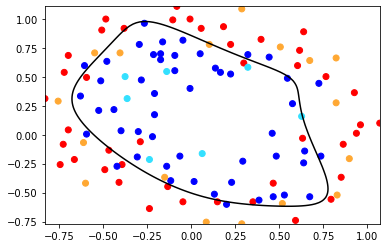

In [16]:
plot_data(X_train, Y_train.reshape((Y_train.shape[0],)))#_train
plot_data(X_test, Y_test.reshape((Y_test.shape[0],)), color_map = cm_bright_test)

plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [17]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [18]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

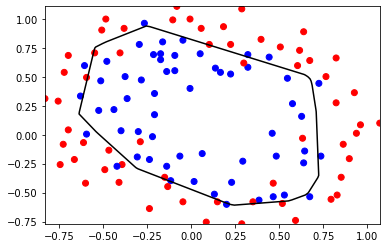

In [19]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [20]:
accuracy_score(Y, clf.predict(X))

0.8389830508474576